In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
import catboost
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
%matplotlib inline

# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)


import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
print ("Ready!")


['train_identity.csv', 'test_transaction.csv', 'train_transaction.csv', 'test_identity.csv', 'sample_submission.csv']
Ready!


In [2]:
X_train=np.load('X_train.npy')
X_test=np.load('X_test.npy')
y_train=np.load('y_train.npy')

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
X_train[np.isnan(X_train)]=-999
X_test[np.isnan(X_test)]=-999

In [5]:
X_train=reduce_mem_usage(X_train)
X_test=reduce_mem_usage(X_test)

AttributeError: 'numpy.ndarray' object has no attribute 'memory_usage'

In [16]:
%%time
from lightgbm import LGBMClassifier
NFOLDS = 5
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=123)

y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
score = 0
  
for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train, y_train)):

    X_tr, X_vl = X_train[tr_idx, :], X_train[val_idx, :]
    y_tr, y_vl = y_train[tr_idx], y_train[val_idx]
    
    clf = LGBMClassifier(
            device = 'gpu',
            verbose=-1, )

    clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_vl, y_vl)], 
        eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
    
    y_pred_train= clf.predict_proba(X_vl, num_iteration=clf.best_iteration_)[:, 1]
    y_oof[val_idx] = y_pred_train
    print("FOLD: ",fold,' AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    score += roc_auc_score(y_vl, y_pred_train) / NFOLDS
    y_preds+= clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / NFOLDS
    
    del X_tr, X_vl, y_tr, y_vl
    gc.collect()
    
    
print("\nMEAN AUC = {}".format(score))
print("OOF AUC = {}".format(roc_auc_score(y_train, y_oof)))

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.0706488	training's auc: 0.940581	valid_1's binary_logloss: 0.0772391	valid_1's auc: 0.924686
FOLD:  0  AUC 0.9246857671684408
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.070971	training's auc: 0.941442	valid_1's binary_logloss: 0.0752186	valid_1's auc: 0.931181
FOLD:  1  AUC 0.931180905285989
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.0702753	training's auc: 0.94214	valid_1's binary_logloss: 0.0764846	valid_1's auc: 0.929399
FOLD:  2  AUC 0.9293985818221053
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.0701666	training's auc: 0.943412	valid_1'

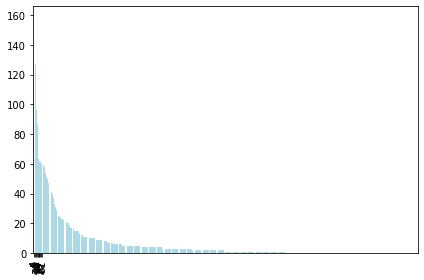

In [22]:
importaces=clf.feature_importances_
#重要な特徴量順にインデックス番号を取得
indices=np.argsort(importaces)[::-1]
feat_labels=np.arange(X_train.shape[1])

plt.bar(range(X_train.shape[1]),importaces[indices],color='lightblue',align='center')
plt.xticks(range(X_train.shape[1])[:10],feat_labels[indices][:10],rotation=90)
plt.xlim([-1,X_train.shape[1]])
plt.tight_layout()
plt.show()

AttributeError: 'LGBMClassifier' object has no attribute 'get_booster'

In [28]:
sub=pd.read_csv('../input/sample_submission.csv',index_col='TransactionID')
sub['isFraud']=y_preds
sub.to_csv('EDA_lightgbm.csv')

In [29]:
sub.head()

,isFraud
TransactionID,
3663549,0.003952
3663550,0.013237
3663551,0.011359
3663552,0.007815
3663553,0.004537
